- NASA数据集，b0005，b0006，b0007
- 留一法验证
- V，I，T为输入
- CNN1：1*30向量输入
- CNN2：3*10矩阵输入

In [1]:
import os
import glob
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchsummary import summary

Duplicate key in file PosixPath('/home/lxh/miniconda3/envs/rul_prediction/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'), line 268 ('font.family         : sans-serif        ')
Duplicate key in file PosixPath('/home/lxh/miniconda3/envs/rul_prediction/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'), line 272 ('font.sans-serif: DejaVu Sans, Bitstream Vera Sans, Computer Modern Sans Serif, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif')


In [4]:
# pandas测试
data_root_path = "/home/lxh/Desktop/battery_datasets/nasa/5_Battery_Data_Set/1_BatteryAgingARC-FY08Q4"
train_csv_file_path = os.path.join(data_root_path, "nasa_b0005_train.csv")
test_csv_file_path = os.path.join(data_root_path, "nasa_b0005_test.csv")

data = pd.read_csv(train_csv_file_path, header=None)
# print(type(data)) # <class 'pandas.core.frame.DataFrame'>
# print(data.shape) # (118, 31)
data = data.values
# print(type(data)) # <class 'numpy.ndarray'>
# print(data.shape) # (118, 31)

files = glob.glob(os.path.join("./nasa_battery_aging_dataset/", "*.csv"))
for file in files:
    data = pd.read_csv(file, header=None)
    break
np.array(data).shape

data = np.array(range(30))
print(data.reshape(3, 10))

[[ 0  1  2  3  4  5  6  7  8  9]
 [10 11 12 13 14 15 16 17 18 19]
 [20 21 22 23 24 25 26 27 28 29]]


In [5]:
class BatteryDataset(Dataset):
    def __init__(self, path, train=True, transform=None, target_transform=None):
        self.mode = "train" if train == True else "test"
        self.path = path
        self.data = pd.read_csv(path, header=None).values # 转为numpy.array
        self.transform = transform
        self.target_transform = target_transform

    def __get_data__(self):
        pass

    def __len__(self):
        return len(self.data)
    
    # def __getitem__(self, index): 
    #     # 通过index取数据
    #     # 实现ndarray2tensor（通过transform）
    #     # self.data = self.data.values
    #     print(type(index), index)
    #     if type(index) == int:
    #         features = self.data[index][:-1]
    #         label = data[index][-1]
    #         if self.transform is not None:
    #             features = self.transform(features).reshape((1, 1, 30)) # [C, H, W]
    #         if self.target_transform is not None:
    #             label = self.target_transform(label)
    #         return features, label
    #     elif type(index) == slice:
    #         for i in self.data[index]:
    #             features

    def __getitem__(self, index): 
        # 通过index取数据
        # 实现ndarray2tensor（通过transform）
        # self.data = self.data.values
        features = self.data[index][:-1]
        label = np.array(self.data[index][-1])
        return torch.FloatTensor(features).reshape(1, 1, 30), torch.FloatTensor(label)
    
class NASADataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        return self.data[index]

In [11]:
data = glob.glob(os.path.join("./nasa_battery_aging_dataset/", "*.csv")) # ['./nasa_battery_aging_dataset/b0005.csv', './nasa_battery_aging_dataset/b0006.csv', './nasa_battery_aging_dataset/b0007.csv']

# 设置train_dataset和test_dataset
b0005 = BatteryDataset(path=data[0])
b0006 = BatteryDataset(path=data[1])
b0007 = BatteryDataset(path=data[2])
train_dataset, test_dataset = b0006 + b0007, b0005
# train_dataset, test_dataset = b0005 + b0006, b0007
# train_dataset, test_dataset = b0005 + b0007, b0006

# 查看dataset
# print(train_dataset) # <torch.utils.data.dataset.ConcatDataset object at 0x7f4208a97a00>
# print(test_dataset) # <__main__.BatteryDataset object at 0x7f4208b7e430>
# print(test_dataset[0])

# 设置dataloader
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# 查看dataloader
# real_batch = next(iter(train_dataloader)) # 返回一个batch的数据
# print(type(real_batch), len(real_batch)) # real_batch be like [all_features, all_labels]
# print(real_batch[1])

[(tensor([[[0.6599, 0.8502, 0.9682, 1.0000, 1.0000, 0.9806, 0.6857, 0.9777,
          0.9104, 0.5831, 0.9477, 0.9994, 0.9504, 0.6252, 0.3601, 0.2237,
          0.3127, 0.4649, 0.6228, 0.7530, 0.2066, 0.3861, 0.4848, 0.4620,
          0.4250, 0.2480, 0.2646, 0.3398, 0.3385, 0.3876]]]), tensor(1.)), (tensor([[[0.0000, 0.0333, 0.0464, 0.0637, 0.1394, 0.5991, 0.7509, 0.9569,
          0.9835, 0.5825, 0.9636, 0.9993, 0.9993, 0.9994, 0.9993, 0.9207,
          0.8082, 0.8645, 0.9013, 0.7928, 0.8052, 0.6239, 0.4057, 0.4164,
          0.7917, 0.9750, 0.8285, 0.6992, 0.5438, 0.5343]]]), tensor(0.9939)), (tensor([[[0.0143, 0.0233, 0.0306, 0.0409, 0.0891, 0.4310, 0.8310, 0.9464,
          0.9657, 0.5396, 0.9629, 0.9995, 0.9993, 0.9996, 0.9994, 0.9504,
          0.8681, 0.9034, 0.9396, 0.8175, 0.8425, 0.6653, 0.4327, 0.4353,
          0.8072, 1.0000, 0.8955, 0.7640, 0.5912, 0.5737]]]), tensor(0.9761)), (tensor([[[0.0344, 0.0249, 0.0296, 0.0390, 0.0941, 0.4769, 0.7560, 0.9355,
          0.9693, 0.53

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")

# writer = SummaryWriter("./logs/cnn_1/")

class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=30, kernel_size=(1, 2), stride=(1, 1))
        self.relu1 = nn.LeakyReLU(negative_slope=0.1)
        self.conv2 = nn.Conv2d(in_channels=30, out_channels=10, kernel_size=(1,2), stride=(1, 1))
        self.relu2 = nn.LeakyReLU(negative_slope=0.1)
        self.fc1 = nn.Linear(10 * 1 * 28, 140) 
        # self.fc = nn.Linear(10 * 1 * 28, 1)
        self.fc2 = nn.Linear(140, 1)
        self.fc3 = nn.Linear(140, 70)
        self.fc4 = nn.Linear(70, 1)

    def forward(self, x):
        input_size = x.size(0) # batch_size ([batch_size, C, H, W])
        x = self.conv1(x) # [batch_size, 1, 1, 30] -> [batch_size, 30, 1, 29]
        x = self.relu1(x) # [batch_size, 30, 1, 29] -> [batch_size, 30, 1, 29]
        x = self.conv2(x) # [batch_size, 30, 1, 29] -> [batch_size, 10, 1, 28]
        x = self.relu2(x) # [batch_size, 10, 1, 28] -> [batch_size, 10, 1, 28]
        x = x.view(input_size, -1) # [batch_size, 10, 1, 28] -> [batch_size, 280]
        x = self.fc1(x) # [batch_size, 280] -> [batch_size, 140]
        x = self.fc2(x) # [batch_size, 140] -> [batch_size, 70]
        # x = self.fc3(x)
        # x = self.fc4(x)
        return x

class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=30, kernel_size=(3, 3), stride=(1, 1), padding=1)
        self.relu1 = nn.LeakyReLU(negative_slope=0.1)
        self.conv2 = nn.Conv2d(in_channels=30, out_channels=10, kernel_size=(3,3), stride=(1, 1))
        self.relu2 = nn.LeakyReLU(negative_slope=0.1)
        self.fc1 = nn.Linear(10 * 1 * 8, 40) 
        self.fc2 = nn.Linear(40, 20)
        self.fc3 = nn.Linear(20, 1)

    def forward(self, x):
        input_size = x.size(0) # batch_size ([batch_size, C, H, W])
        x = self.conv1(x) # [batch_size, 1, 3, 10] -> [batch_size, 30, 3, 10]
        x = self.relu1(x) # [batch_size, 30, 3, 10] -> [batch_size, 30, 3, 10]
        x = self.conv2(x) # [batch_size, 30, 3, 10] -> [batch_size, 10, 1, 8]
        x = self.relu2(x) # [batch_size, 10, 1, 8] -> [batch_size, 10, 1, 8]
        x = x.view(input_size, -1) # [batch_size, 10, 1, 8] -> [batch_size, 80]
        x = self.fc1(x) # [batch_size, 80] -> [batch_size, 40]
        x = self.fc2(x) # [batch_size, 40] -> [batch_size, 20]
        x = self.fc3(x) # [batch_size, 20] -> [batch_size, 1]
        return x

torch.manual_seed(3407)
model = CNN1().to(device)
print(model)
# input = torch.randn(1, 1, 3, 10).to(device)
# writer.add_graph(model, input)
# writer.close()
print(summary(model, (1, 1, 30)))

using device: cuda
CNN1(
  (conv1): Conv2d(1, 30, kernel_size=(1, 2), stride=(1, 1))
  (relu1): LeakyReLU(negative_slope=0.1)
  (conv2): Conv2d(30, 10, kernel_size=(1, 2), stride=(1, 1))
  (relu2): LeakyReLU(negative_slope=0.1)
  (fc1): Linear(in_features=280, out_features=140, bias=True)
  (fc2): Linear(in_features=140, out_features=1, bias=True)
  (fc3): Linear(in_features=140, out_features=70, bias=True)
  (fc4): Linear(in_features=70, out_features=1, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 30, 1, 29]              90
         LeakyReLU-2            [-1, 30, 1, 29]               0
            Conv2d-3            [-1, 10, 1, 28]             610
         LeakyReLU-4            [-1, 10, 1, 28]               0
            Linear-5                  [-1, 140]          39,340
            Linear-6                    [-1, 1]             141
Total params: 4

开始训练
训练完成


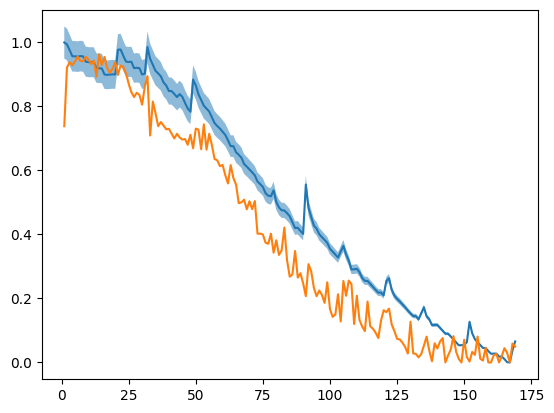

In [213]:
def train(dataloader, model, loss_fn, optimizer, epoch):
    size = len(dataloader.dataset) # 样本总数
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device).reshape(-1, 1)
        # 计算预测损失
        pred = model(X)
        # print("y: ", type(y), y.dtype, y.shape)
        # print("pred: ", type(pred), y.dtype, pred.shape)
        pred, y = pred.to(torch.float32), y.to(torch.float32)
        loss = loss_fn(pred, y)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 每训练完一个batch打印一次损失信息
        loss, current = loss.item(), (batch + 1) * len(X)
        # print(f"epoch: {epoch + 1}, loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.constant_(m.bias, 0)
# 也可以判断是否为conv2d，使用相应的初始化方式 
    elif isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
# 是否为批归一化层
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

torch.manual_seed(3407)
model = CNN1().to(device)
model.apply(weight_init)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

epochs = 400
print("开始训练")
for epoch in range(epochs):
    train(train_dataloader, model, criterion, optimizer, epoch)
print("训练完成")

import matplotlib.pyplot as plt

# ym, yr = 1.2874525221379407, 0.5725474778620594

y1, gt, y2 = [], [], []
y_pred = []
cycle = [i + 1 for i in range(len(test_dataset))]

for idx, (X, y) in enumerate(test_dataset):
    y_pred.append(float(model(X.to(device))))
    y1.append(y * (1 + 0.05))
    gt.append(y)
    y2.append(y * (1 - 0.05))

plt.plot(cycle, gt)
plt.fill_between(cycle, y1, y2, alpha=0.5)
plt.plot(cycle, y_pred)

In [101]:
# writer = SummaryWriter(log_dir="logs")

def test(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device).reshape(-1, 1)
            pred = model(X)
            pred, y = pred.to(torch.float32), y.to(torch.float32)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    print(f"Avg loss: {test_loss:>8f} \n")

test(test_dataloader, model, criterion)

torch.Size([128, 1, 3, 10])
torch.Size([41, 1, 3, 10])
Avg loss: 0.021277 



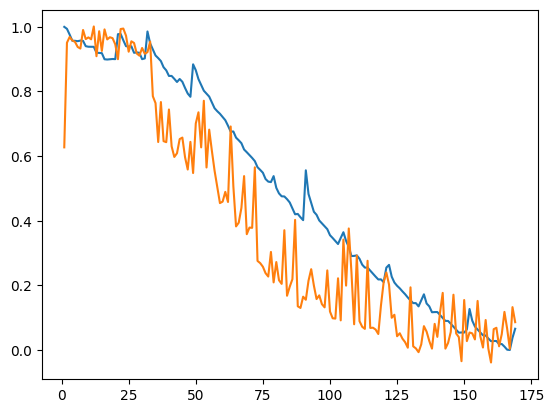

In [71]:
import matplotlib.pyplot as plt

# ym, yr = 1.2874525221379407, 0.5725474778620594

gt = []
y_pred = []
cycle = [i + 1 for i in range(len(test_dataset))]

for idx, (X, y) in enumerate(test_dataset):
    y_pred.append(float(model(X.to(device))))
    gt.append(y)

plt.plot(cycle, gt)
plt.plot(cycle, y_pred)